# <center>Network Science</center>

Home Assignment #2: Community Detection

In [1]:
%load_ext autoreload
%autoreload 2

In [182]:
import pandas as pd
from ipywidgets import interact, widgets
import numpy as np
import networkx as nx
from scipy.spatial import distance
import community as co
from sklearn.cluster import AgglomerativeClustering
from src.visualize import draw_network
import matplotlib.pyplot as plt
%matplotlib inline

In [134]:
pdist?

In [126]:
dendrogram?

#### <hr /> General Information

**Due Date:** 03.06.2020 21:00 <br>
**Late submission policy:** -1 points per day <br>


Please send your reports to <iakarpov@hse.ru> with message subject of the following structure: <br>
**[HSE SNA Magolego 2020] *{LastName}* *{First Name}* HW_2*

Support your computations with figures and comments. <br>
If you are using IPython Notebook you may use this file as a starting point of your report.

if your network is too big and takes too much time to compute( > 2000 nodes), use `cores` algorithm to make it smaller <br>

## Problems

### Task 1. Network community detection

Use any existing network from our [classes](https://dl.dropboxusercontent.com/s/8eo1sjfhu5spb0f/vk.tsv?dl=1)  or your couse project

1.1. Using Gephi or [NetworkX](https://networkx.github.io/documentation/stable/reference/algorithms/community.html) implement community detection task, using one of the possible algorithms: modularity, label propagation, girvan newman, louvain <br>
1.2. Vizualize your graph in gephi, networkX or grahistry and give a short interpretation <br>


In [3]:
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import label_propagation_communities
from networkx.algorithms.community import asyn_lpa_communities
from networkx.algorithms.community.centrality import girvan_newman

In [4]:
vkdata = pd.read_csv('./data/vk.tsv', sep='\t', index_col=0)
vkdata['Friends'] = vkdata['Friends'].apply(lambda x : x.replace('VK_', 'id'))
vkdata['ID'] = vkdata['ID'].apply(lambda x : x.replace('VK_', 'id'))
print(vkdata.shape[0])
vkdata.head()

125625


,Friends,ID,Name
0,id4766099,id97803804,Никита Кузнецов
1,id5227712,id97803804,Никита Кузнецов
2,id11047376,id97803804,Никита Кузнецов
3,id11079816,id97803804,Никита Кузнецов
4,id14492163,id97803804,Никита Кузнецов


In [49]:
dreamteam = ['Александра Корецкая', 'Даша Ким', 'Илья Селиванов']
fcount = vkdata.groupby('Name').count()['Friends'].to_frame().sort_values(by='Friends', ascending=False)
fcount.loc[dreamteam]

,Friends
Name,
Александра Корецкая,114
Даша Ким,59
Илья Селиванов,50


In [46]:
G = nx.from_pandas_edgelist(vkdata, source='ID', target='Friends')
seed = set(vkdata[vkdata.Name.isin(dreamteam)].ID.unique())
seed_and_friends = list(set(vkdata[(vkdata.ID.isin(seed)) | (vkdata.Friends.isin(seed))].Friends.unique()) | seed)

In [51]:
G = G.subgraph(seed_and_friends)

In [52]:
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

Number of nodes: 115
Number of edges: 604


In [53]:
%%time
# Modularity
mod_communities = greedy_modularity_communities(G)
len(mod_communities)

CPU times: user 37.7 ms, sys: 33 µs, total: 37.7 ms
Wall time: 37 ms


5

In [111]:
def iterable_to_partition(communities) -> dict:
    partition = {}
    for i, c in enumerate(communities):
#         print(i)
        for node in c:
            partition[node] = i
    return partition

In [71]:
mod_partition = iterable_to_partition(mod_communities)

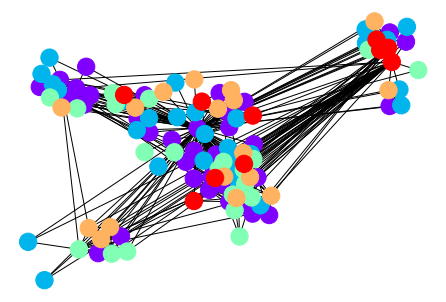

In [67]:
draw_network(G, mod_partition)

In [112]:
%%time
# Asynchronous Label Propagation
lpa_communities = asyn_lpa_communities(G)

CPU times: user 24.7 ms, sys: 16 µs, total: 24.7 ms
Wall time: 24.3 ms


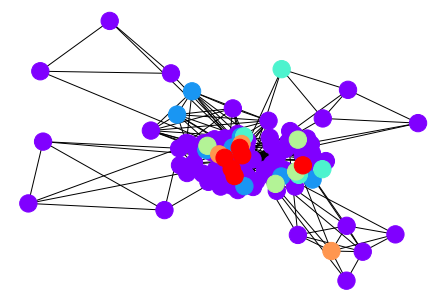

In [113]:
lpa_partition = iterable_to_partition(lpa_communities)
draw_network(G, lpa_partition)

In [118]:
%%time
# Girvan-Newman
gn_communities = list(girvan_newman(G))

CPU times: user 5.88 s, sys: 2.8 ms, total: 5.88 s
Wall time: 5.88 s


In [132]:
@interact
def show_clusters(level=(0, 113, 3)):
    gn_partition = iterable_to_partition(gn_communities[level])
    draw_network(G, lpa_partition)

interactive(children=(IntSlider(value=54, description='level', max=113, step=3), Output()), _dom_classes=('wid…

In [64]:
%%time
# Louvain
lou_communities = co.community_louvain.best_partition(G)

CPU times: user 17.9 ms, sys: 45 µs, total: 17.9 ms
Wall time: 17.7 ms


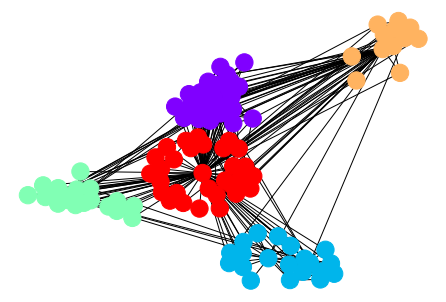

In [65]:
draw_network(G, lou_communities)

__________

### Task 2. Assortativity and clustering

+2.1. Create affinity matrix using cosine or eucledian distances (see distance.pdist from Assortativity.ipynb) <br>
+2.2. Get cluster labels using one of the existing clustering algorithms to the affinity matrix (see https://scikit-learn.org/stable/modules/clustering.html) <br>
+2.3.  Vizualize your graph in gephi, networkX or grahistry and give short interpretation <br>

useful advices: <br>
use affinity='precomputed' for the clustering algorithm <br>

In [136]:
A = nx.to_numpy_matrix(G, dtype=int)
A = np.asarray(A)

In [145]:
def plot_distances(A):
    
    f, ax = plt.subplots(2, 2, figsize=(10,10))
    ax[0, 0].imshow(A, cmap='PiYG', interpolation='None')
    ax[0, 0].set_title('Adjacency Matrix')
    
    D = np.corrcoef(A)
    ax[1, 0].imshow(D, cmap='PiYG', interpolation='None')
    ax[1, 0].set_title('Correlation coeff.')
    
    dVec = distance.pdist(A, metric = 'euclidean')
    D = distance.squareform(dVec)
    ax[0, 1].imshow(D, cmap='PiYG', interpolation='None')
    ax[0, 1].set_title('Euclidean Dist.')
    
    dVec = distance.pdist(A, metric='cosine')
    D = distance.squareform(dVec)
    ax[1, 1].imshow(D, cmap='PiYG', interpolation='None')
    ax[1, 1].set_title('Cosine Dist.') 
    

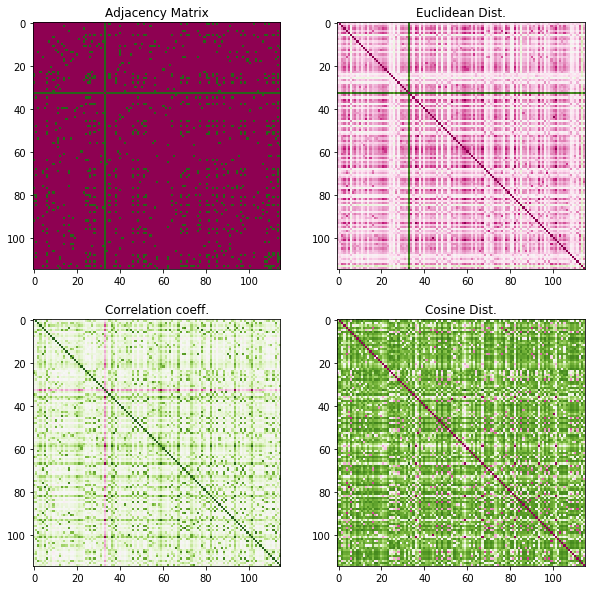

In [146]:
plot_distances(A)   

In [175]:
D_cor = np.corrcoef(A)
D_euc = distance.squareform(distance.pdist(A, metric='euclidean'))
D_cos = distance.squareform(distance.pdist(A, metric='cosine'))

dists = dict(cor=D_cor, euc=D_euc, cos=D_cos)

In [183]:
@interact
def cluster_and_show(N=widgets.IntSlider(min=1, max=115, step=1, value=3), D=list(dists.keys())):
    nodes = list(G.nodes())
    AC = AgglomerativeClustering(n_clusters=N, affinity='precomputed', linkage='complete')
    clusters = AC.fit_predict(dists[D])
    clusters = dict(zip(nodes, clusters))
    draw_network(G, clusters)

interactive(children=(IntSlider(value=3, description='N', max=115, min=1), Dropdown(description='D', options=(…